In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
import os.path as osp
from tqdm.auto import tqdm
from os.path import dirname, join
from glob import glob
import matplotlib
matplotlib.rcParams.update({'font.size': 12})
from analysis.plot_matplotlib import plot_hist, export_figures
#module_reload('analysis')
from analysis.mem_ana import load_results, parse_line_to_float, finalize_mems
from analysis.mc.tools import variance_weighted_result
from analysis.utils import module_reload

In [2]:
repo_dir = '/afs/desy.de/user/b/bliewert/public/MarlinWorkdirs/MEM_HEP'

In [29]:
src_path = "/nfs/dust/ilc/user/bliewert/vegas_consistency/results"
events = os.listdir(src_path)

keys = ['sig', 'bkg']
results = {  }

for event in events:
    files = glob(f'/nfs/dust/ilc/user/bliewert/vegas_consistency/results/{event}/summary_*.npy')
    result = {
        'res_zhh': [],
        'res_zzh': [],
        'sigma_zhh': [],
        'sigma_zzh': []
    }
    
    for file in files:
        npy = np.load(file, allow_pickle=True).item()
        
        result['res_zhh'].append(npy['sig']['means'][0])
        result['res_zzh'].append(npy['bkg']['means'][0])
        result['sigma_zhh'].append(npy['sig']['sigmas'][0])
        result['sigma_zzh'].append(npy['bkg']['sigmas'][0])
    
    result['zhh_mem'] = finalize_mems(np.array(result['res_zhh']), assume_zhh=True)
    result['zzh_mem'] = finalize_mems(np.array(result['res_zzh']), assume_zzh=True)
    result['r'] = result["zhh_mem"]/(result["zhh_mem"] + result["zzh_mem"])
    
    results[event] = pd.DataFrame(result)

Analysis

In [32]:
for key, df in results.items():
    print(key)
    print(np.average(df['res_zhh']), np.average(df['sigma_zhh']))
    print(np.average(df['res_zzh']), np.average(df['sigma_zzh']))

event_82391
2.2970399331295022e-17 8.449099319003553e-19
4.719907410604877e-16 3.342070778157822e-19
event_13287
5.091466974687783e-20 5.997491241044572e-21
1.0737490581921264e-19 1.4250922744056615e-21


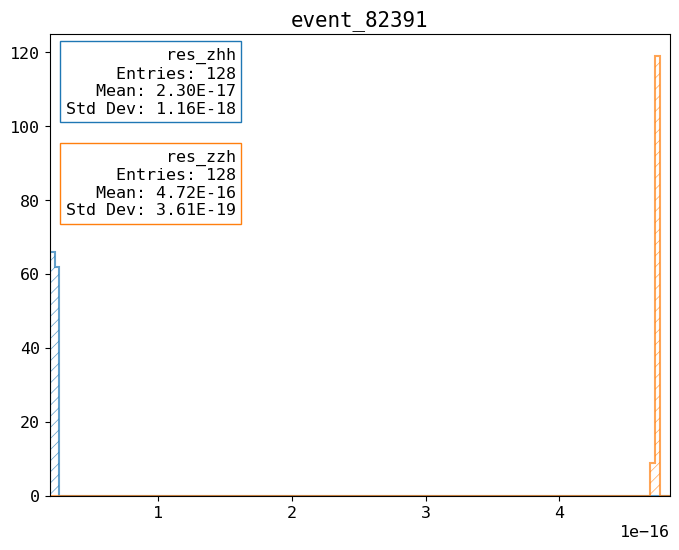

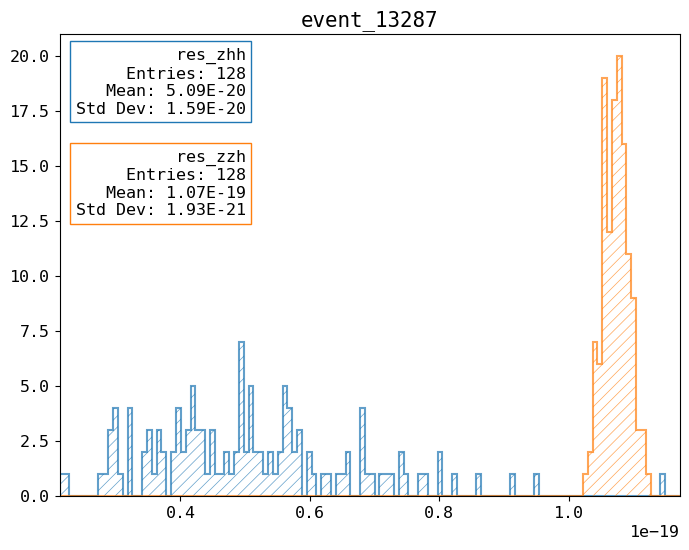

In [33]:
for key, df in results.items():
    plot_hist(df, x=['res_zhh', 'res_zzh'], title=f'{key}', scientific_stats=True, text_start_x=.3,);

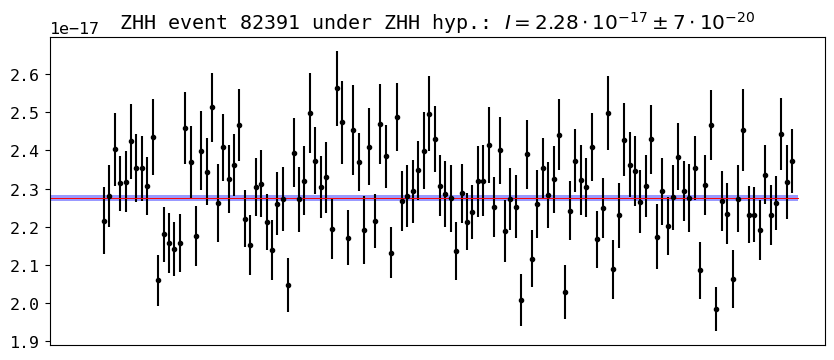

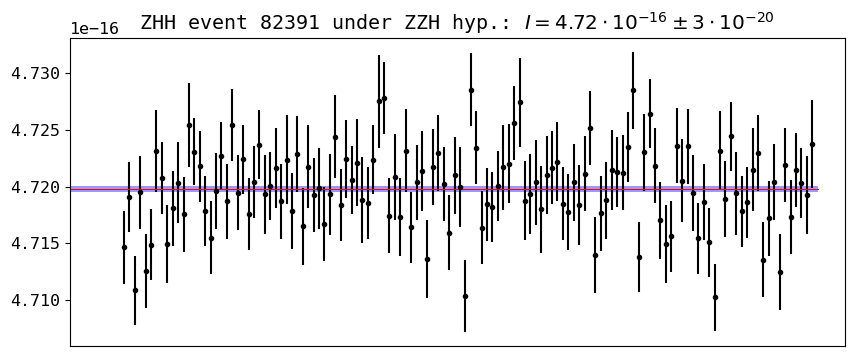

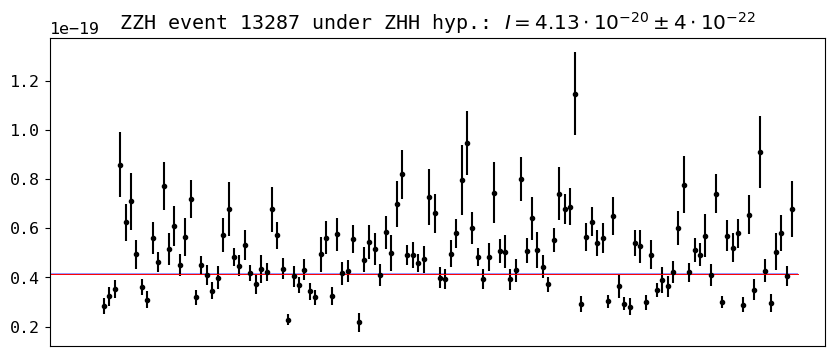

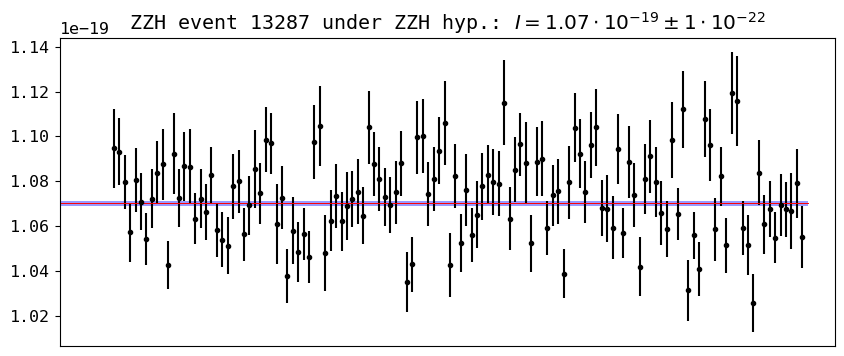

In [34]:
from matplotlib.patches import Rectangle
from math import floor, log10

def fexp(f):
    return int(floor(log10(abs(f)))) if f != 0 else 0

def fman(f):
    return f/10**fexp(f)

figures = []

for event, df in results.items():
    event_idx = int(event.replace("event_", ""))
    is_zhh = (event_idx == 82391)
    is_zzh = (event_idx == 13287)
    
    for key in ['zhh', 'zzh']:
        sample_ratio = 1
        sample_mask = np.arange(int(sample_ratio*len(df)))
        
        mean_tot, sigma_tot = variance_weighted_result(df[f'res_{key}'][sample_mask].to_numpy(), df[f'sigma_{key}'][sample_mask].to_numpy())

        xmax = len(sample_mask)

        fig, ax = plt.subplots(figsize=(10,4))
        ax.errorbar(np.arange(xmax), df[f'res_{key}'][sample_mask], yerr=df[f'sigma_{key}'][sample_mask], fmt='.k');
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        
        start_left = -10#ax.get_xlim()[0]
        p1 = ax.plot([start_left, xmax], [mean_tot]*2, color='red', linewidth=.7)
        ax.set_xlim(-10, xmax+5)
        #ax.fill_between([0, xmax], [mean_tot-sigma_tot, mean_tot], [mean_tot, mean_tot+sigma_tot])
        p2 = ax.add_patch(Rectangle((start_left, mean_tot-sigma_tot), xmax-start_left, 2*sigma_tot, facecolor="blue", alpha=0.4))
        
        p1[0].set_clip_on(False)
        p2.set_clip_on(False)
        
        mean_str  = f'{fman(mean_tot):.2f} \cdot 10^' + "{" + f'{fexp(mean_tot)}' + "}"
        sigma_str = f'{fman(sigma_tot):.0f} \cdot 10^' + "{" + f'{fexp(sigma_tot)}' + "}"

        ax.set_title(rf'{"ZHH" if is_zhh else "ZZH" if is_zzh else None} event {event_idx} under {key.upper()} hyp.: $I = {mean_str} \pm {sigma_str} $')
        
        plt.show()
        
        figures.append(fig)

export_figures(f'{repo_dir}/notebooks/results/4_mc_consistency_vegas.pdf', figures)

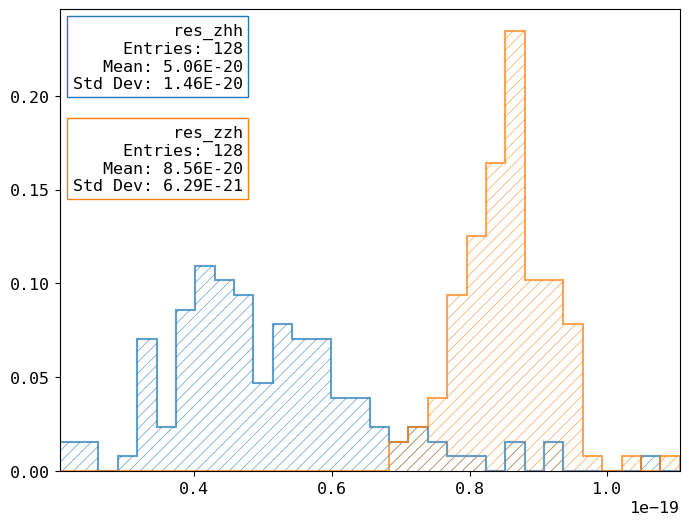

In [24]:
plot_hist(df, x=['res_zhh', 'res_zzh'], scientific_stats=True, bins=32, text_start_x=0.295, normalize=True);

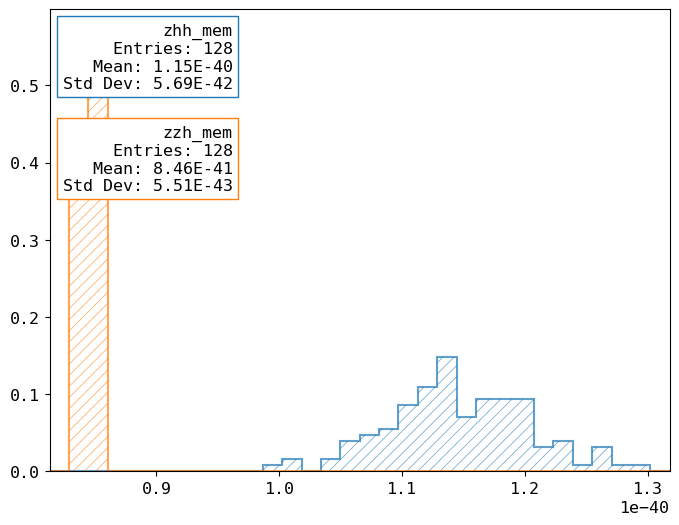

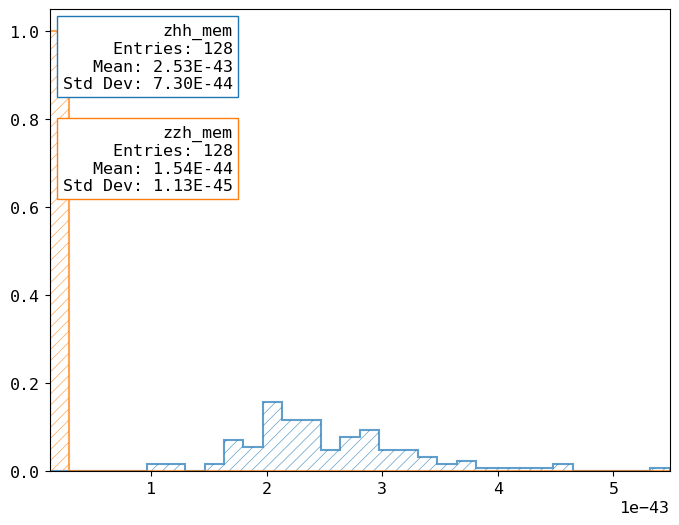

In [27]:
for key, df in results.items():
    plot_hist(df, x=['zhh_mem', 'zzh_mem'], scientific_stats=True, bins=32, text_start_x=0.295, normalize=True);